# Calculate the high vs low years for temperature, ice fraction and nutrietns on a point by point basis (and show annual differences)

##  Units: 
    1. Temperature ($^o$ C)
    2. Ice Fraction (unitless)
    3. NO$_3$ concentration (mmol m$^{-3}$)

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## High vs low temperature 

In [4]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP.*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [5]:
%%time
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 11.1 s, sys: 15.4 s, total: 26.5 s
Wall time: 38.4 s


In [6]:
## Calculate climatology for each grid cell
temp_ao_clim = np.nanmean(temp_ds_inter,axis=0) # Size (12,180,360)

In [7]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
temp_arctic_anom = np.empty([62,12,180,360]) ; temp_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        temp_arctic_anom[:,:,latitude,longitude] = temp_ds_inter[:,:,latitude,longitude]-temp_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

CPU times: user 567 ms, sys: 260 ms, total: 827 ms
Wall time: 845 ms


## Calculate the cold vs the warm years for all the latitudes and longitudes.. 
    1. We have the anonmalies for each latitude and longitude
    2. We have the standard error for each latitude and each longitude 
    3. we want to select the warm and cold years from each latitude and each longitude... 

In [8]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
cold_years_arctic = {}
warm_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
cold_years_arctic = multi_dict(2, int)
warm_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        warm_years_arctic[latitude][longitude] = np.where(np.nanmean(temp_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

## Now make sure that this works and can be used!! 

In [9]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
cold_years_temp = np.empty([12,180,360]) ; cold_years_temp[:] = np.nan
warm_years_temp = np.empty([12,180,360]) ; warm_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        cold_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[cold_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        warm_years_temp[:,latitude,longitude] = np.nanmean(temp_ds_inter[warm_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

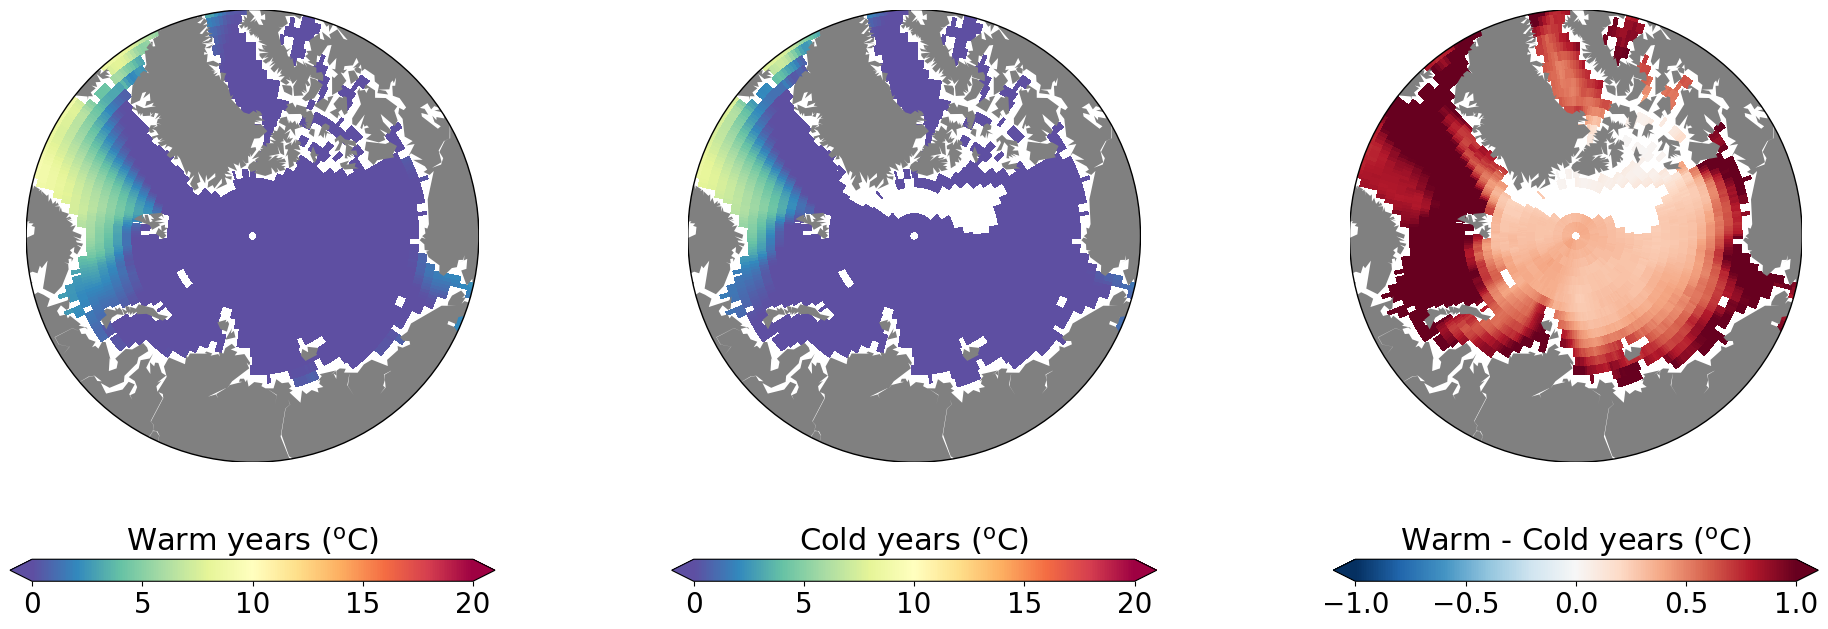

In [10]:
fig = plt.figure(figsize=(20, 20))
lat = ds_01.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(cold_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(warm_years_temp,axis=0), coord=ds_01.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm - Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

## Show that: "The white areas on the map indicate that the temperatures at those locations do not go above or below the average temperature recorded at that grid cell over the 62-year period."

### Step 1: Select a grid cell that shows a white area

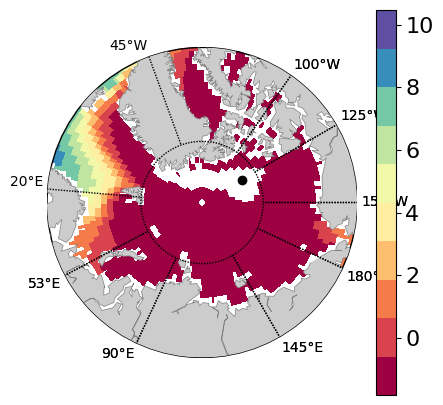

In [11]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True,
            boundinglat=65,
            lon_0=180+(-100+-30)/2.,resolution='c')

m.pcolormesh(x,y,np.nanmean(cold_years_temp,axis=0),shading='flat',cmap=plt.cm.get_cmap('Spectral', 10))
cbar=plt.colorbar() 
cbar.ax.tick_params(labelsize=16)

x1, y1 = m(*np.meshgrid(ds_01.lon[55],ds_01.lat[172]))
m.plot(x1,y1,'o',color='k')

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)
m.plot
plt.show()

### Step 2: Select the information from that grid cell to plot an anomaly and the 1/2 standard deviation thresholds

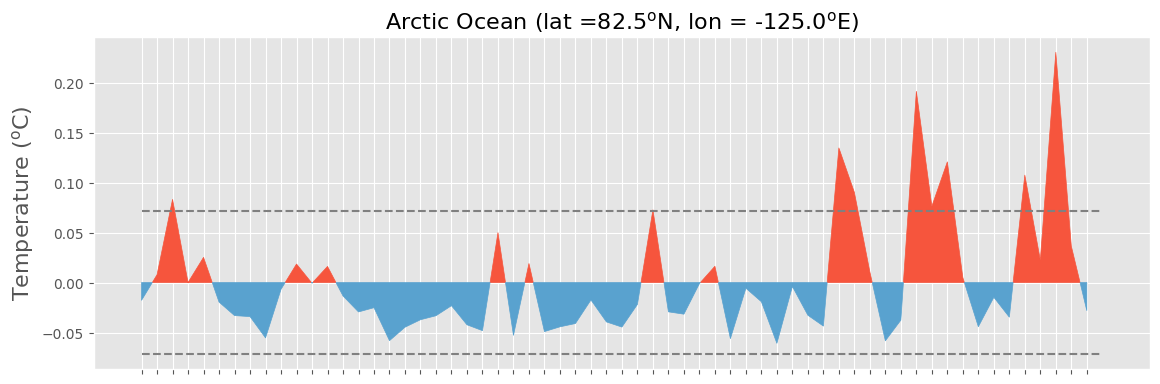

In [12]:
# Checking 
lon = ds_01.lon[55].values
lat = ds_01.lat[172].values
# Therefore, using, ---> np.nanmean(temp_arctic_anom[:,172,55],axis=1)

# Calculating the error at this specfic lat and lon
err_ao = np.nanstd(temp_arctic_anom[:,:,172,55],axis=(0,1));
plt.style.use('ggplot');

years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'];
cmap= matplotlib.cm.get_cmap('Reds', 10);
cmap1= matplotlib.cm.get_cmap('Blues', 10);

fig = plt.figure(figsize=(30, 25));
gs = GridSpec(nrows=5, ncols=2);

# Subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
ax1.fill_between(years, np.nanmean(temp_arctic_anom[:,:,172,55],axis=1), where=np.nanmean(temp_arctic_anom[:,:,172,55],axis=1)>=0, interpolate=True, color=cmap(5));
ax1.fill_between(years, np.nanmean(temp_arctic_anom[:,:,172,55],axis=1), where=np.nanmean(temp_arctic_anom[:,:,172,55],axis=1)<=0, interpolate=True, color=cmap1(5));
plt.hlines(err_ao/2, 0, 62,color='gray',linestyles='dashed');
plt.hlines(-err_ao/2, 0, 62,color='gray',linestyles='dashed');
ax1.set_ylabel('Temperature ($^o$C)', fontsize=16);
ax1.set_title(f'Annual climatology (lat ={lat}$^oN$, lon = {lon}$^oE$)', fontsize=16);
ax1.set_xticklabels('');

## ICE FRACTION

In [13]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [14]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [15]:
## Calculate climatology for each grid cell
ice_ao_clim = np.nanmean(ECOSYS_IFRAC_ds_inter,axis=0) # Size (12,180,360)

In [16]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
ice_arctic_anom = np.empty([62,12,180,360]) ; ice_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        ice_arctic_anom[:,:,latitude,longitude] = ECOSYS_IFRAC_ds_inter[:,:,latitude,longitude]-ice_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

CPU times: user 595 ms, sys: 349 ms, total: 944 ms
Wall time: 962 ms


In [17]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_ice_years_arctic = {}
high_ice_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_ice_years_arctic = multi_dict(2, int)
high_ice_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_ice_years_arctic[latitude][longitude] = np.where(np.nanmean(ice_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [18]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_ice_years_temp = np.empty([12,180,360]) ; low_ice_years_temp[:] = np.nan
high_ice_years_temp = np.empty([12,180,360]) ; high_ice_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_ice_years_temp[:,latitude,longitude] = np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1)) 

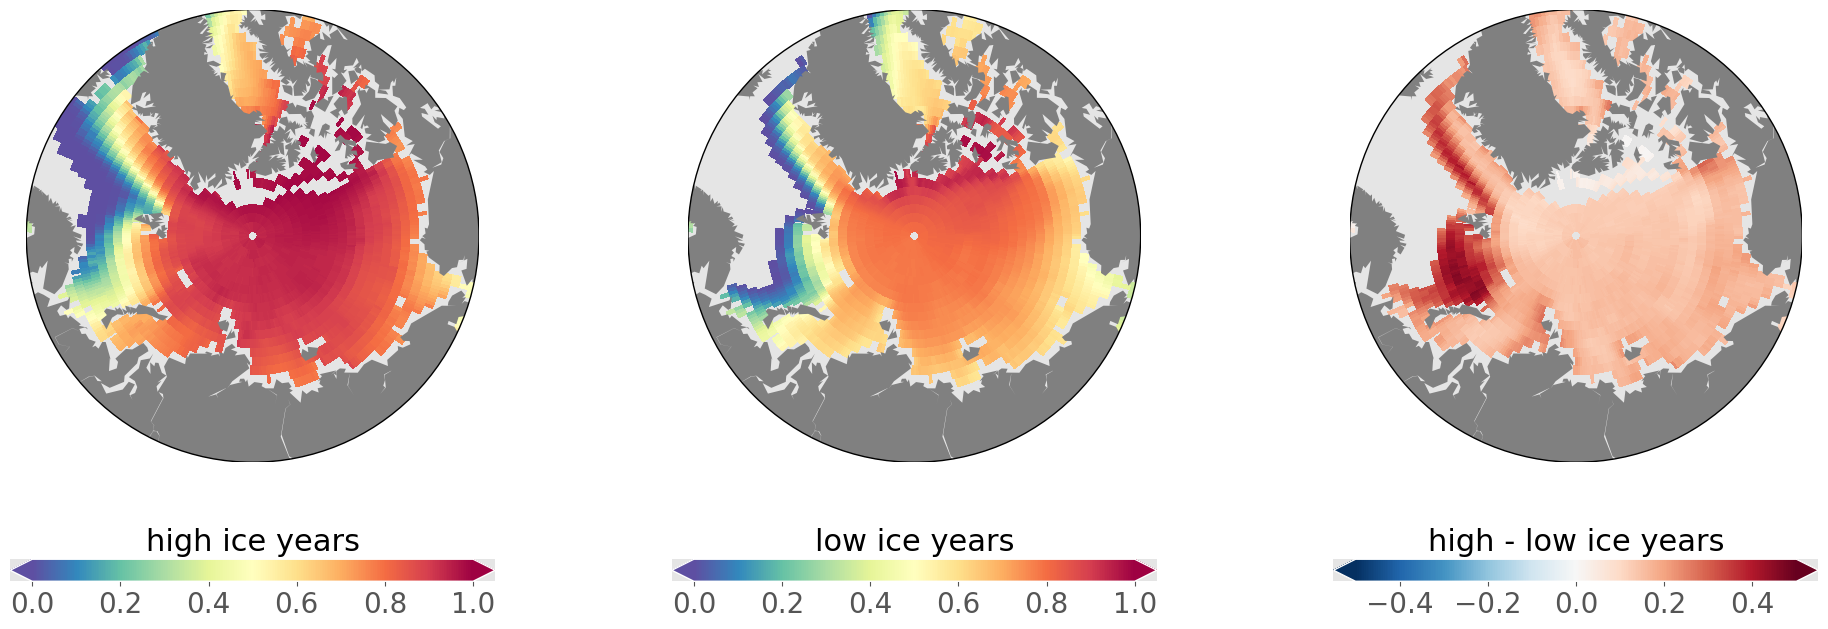

In [19]:
fig = plt.figure(figsize=(20, 20))
lat = ds_02.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_ice_years_temp,axis=0), coord=ds_02.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -0.5, vmax = 0.5)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

## NO$_3$ Years

In [20]:
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [21]:
%%time
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 11.2 s, sys: 15.2 s, total: 26.4 s
Wall time: 35.5 s


In [22]:
## Calculate climatology for each grid cell
no3_ao_clim = np.nanmean(NO3_ds_inter,axis=0) # Size (12,180,360)

In [23]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
no3_arctic_anom = np.empty([62,12,180,360]) ; no3_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        no3_arctic_anom[:,:,latitude,longitude] = NO3_ds_inter[:,:,latitude,longitude]-no3_ao_clim[:,latitude,longitude]

# Calculate the standard deviation from the year and months at each latitude.. 
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

CPU times: user 582 ms, sys: 421 ms, total: 1 s
Wall time: 1.02 s


In [24]:
# Python3 code to demonstrate working of
# Creating Multidimensional dictionary
# Using defaultdict()
from collections import defaultdict
 
# Utility function to create dictionary
def multi_dict(K, type):
    if K == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: multi_dict(K-1, type))
 
# Initialize dictionary
low_no3_years_arctic = {}
high_no3_years_arctic = {}
 
# Using defaultdict()
# Creating Multidimensional dictionary
# calling function
low_no3_years_arctic = multi_dict(2, int)
high_no3_years_arctic = multi_dict(2, int)
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) < -(err_ao[latitude, longitude]/2))
        high_no3_years_arctic[latitude][longitude] = np.where(np.nanmean(no3_arctic_anom[:,:,latitude, longitude],axis=1) > (err_ao[latitude, longitude]/2))

In [25]:
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_temp = np.empty([12,180,360]) ; low_no3_years_temp[:] = np.nan
high_no3_years_temp = np.empty([12,180,360]) ; high_no3_years_temp[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[low_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))
        high_no3_years_temp[:,latitude,longitude] = np.nanmean(NO3_ds_inter[high_no3_years_arctic[latitude][longitude],:,latitude,longitude],axis=(0,1))

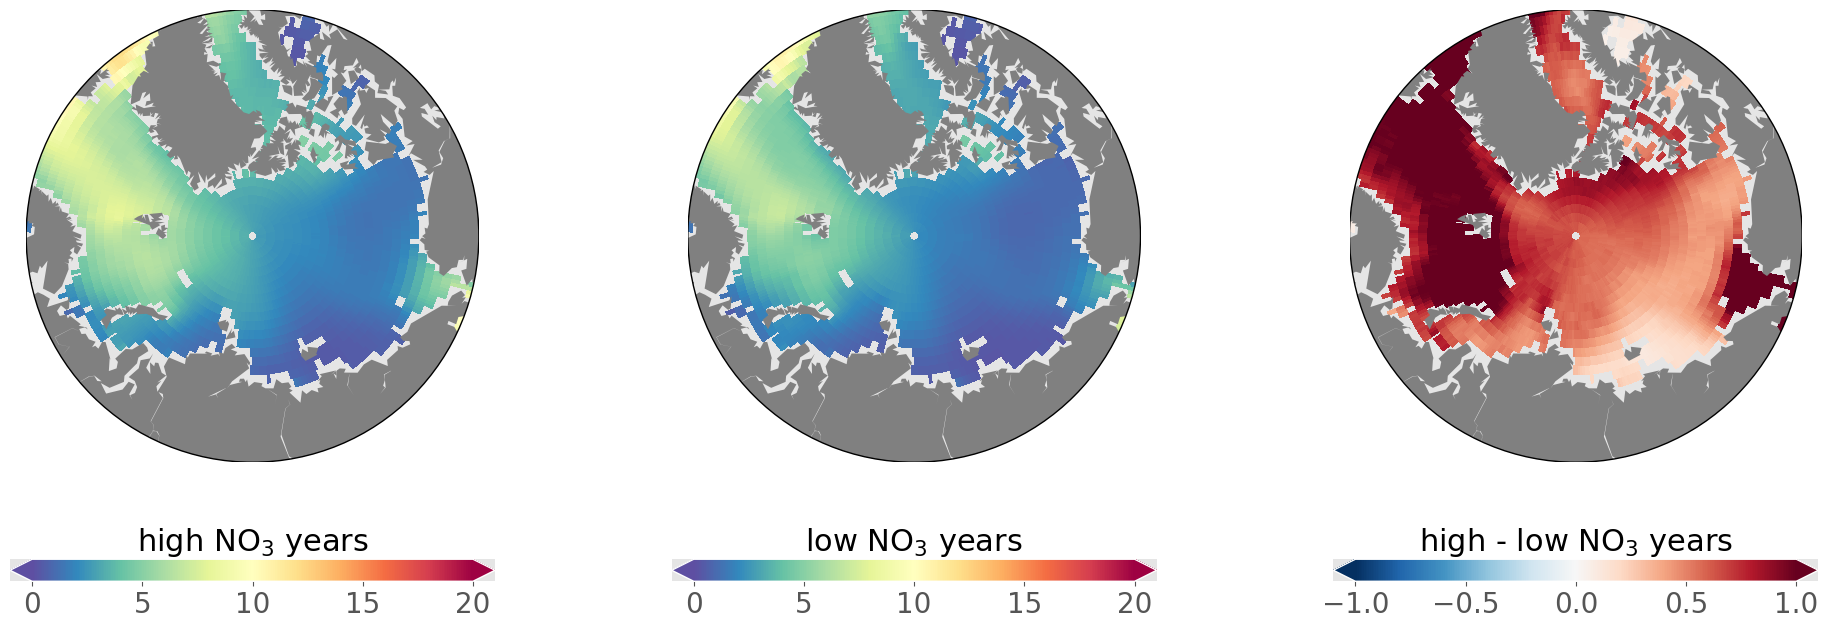

In [26]:
fig = plt.figure(figsize=(20, 20))
lat = ds_03.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(low_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(np.nanmean(high_no3_years_temp,axis=0), coord=ds_03.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('high - low NO$_3$ years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

plt.tight_layout()

## Plot phytoplankton biomass interannually 

In [27]:
path_npy = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/'
bmss = np.load(f'{path_npy}phyto_bmss_62yr_month_regrid.npy')

In [28]:
photoC_TOT = np.nansum(bmss,axis=0) # Size (62, 12, 180, 360)

In [29]:
## Calculate climatology for each grid cell
photoC_ao_clim = np.nanmean(photoC_TOT,axis=0) # Size (12,180,360)
photoC_ao_inter = np.nanmean(photoC_TOT,axis=1) # size (62, 180, 360)

## NO$_3$

In [30]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_no3_years_annual = np.empty([180,360]) ; low_no3_years_annual[:] = np.nan
high_no3_years_annual = np.empty([180,360]) ; high_no3_years_annual[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_no3_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[low_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_no3_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[high_no3_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 758 ms, sys: 31.8 ms, total: 790 ms
Wall time: 931 ms


## Temperature 

In [31]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values. 
low_temp_years_annual = np.empty([180,360]) ; low_temp_years_annual[:] = np.nan
high_temp_years_annual = np.empty([180,360]) ; high_temp_years_annual[:] = np.nan

for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_temp_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[cold_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_temp_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[warm_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 774 ms, sys: 32.3 ms, total: 807 ms
Wall time: 895 ms


## Ice Fraction

In [32]:
%%time
# Loop through the latitudes and longitudes to calculate anomalies and error values.

low_ice_years_annual = np.empty([180,360]) ; low_ice_years_annual[:] = np.nan
high_ice_years_annual = np.empty([180,360]) ; high_ice_years_annual[:] = np.nan
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        low_ice_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[low_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1))
        high_ice_years_annual[latitude,longitude] = np.nanmean(photoC_ao_inter[high_ice_years_arctic[latitude][longitude],latitude,longitude],axis=(0,1)) 
 

CPU times: user 785 ms, sys: 30.6 ms, total: 816 ms
Wall time: 921 ms


## import the ice fraction information

In [33]:
ice_frac_annual = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,:,:],axis=1)

In [34]:
# This is loading the low and high temp, no3 and ice years when averging the whole Arctic... 
# I tried to do it grid by grid, but ice fraction works better when you average throughout the whole Arctic. 
high_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_ice_years_arctic.npy')
low_ice_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_ice_years_arctic.npy')

high_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_no3_years_arctic.npy')
low_no3_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_no3_years_arctic.npy')

high_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/high_temp_years_arctic.npy')
low_temp_years_arctic_avg = np.load('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_npy_files/low_temp_years_arctic.npy')

In [35]:
## NO3
low_no3_years_annual_ice = np.nanmean(ice_frac_annual[low_no3_years_arctic_avg,:,:],axis=(0,1)) 
high_no3_years_annual_ice = np.nanmean(ice_frac_annual[high_no3_years_arctic_avg,:,:],axis=(0,1)) 

## ice
low_ice_years_annual_ice = np.nanmean(ice_frac_annual[low_ice_years_arctic_avg,:,:],axis=(0,1)) 
high_ice_years_annual_ice = np.nanmean(ice_frac_annual[high_ice_years_arctic_avg,:,:],axis=(0,1))  

## temperature
low_temp_years_annual_ice = np.nanmean(ice_frac_annual[low_temp_years_arctic_avg,:,:],axis=(0,1))  
high_temp_years_annual_ice = np.nanmean(ice_frac_annual[high_temp_years_arctic_avg,:,:],axis=(0,1)) 

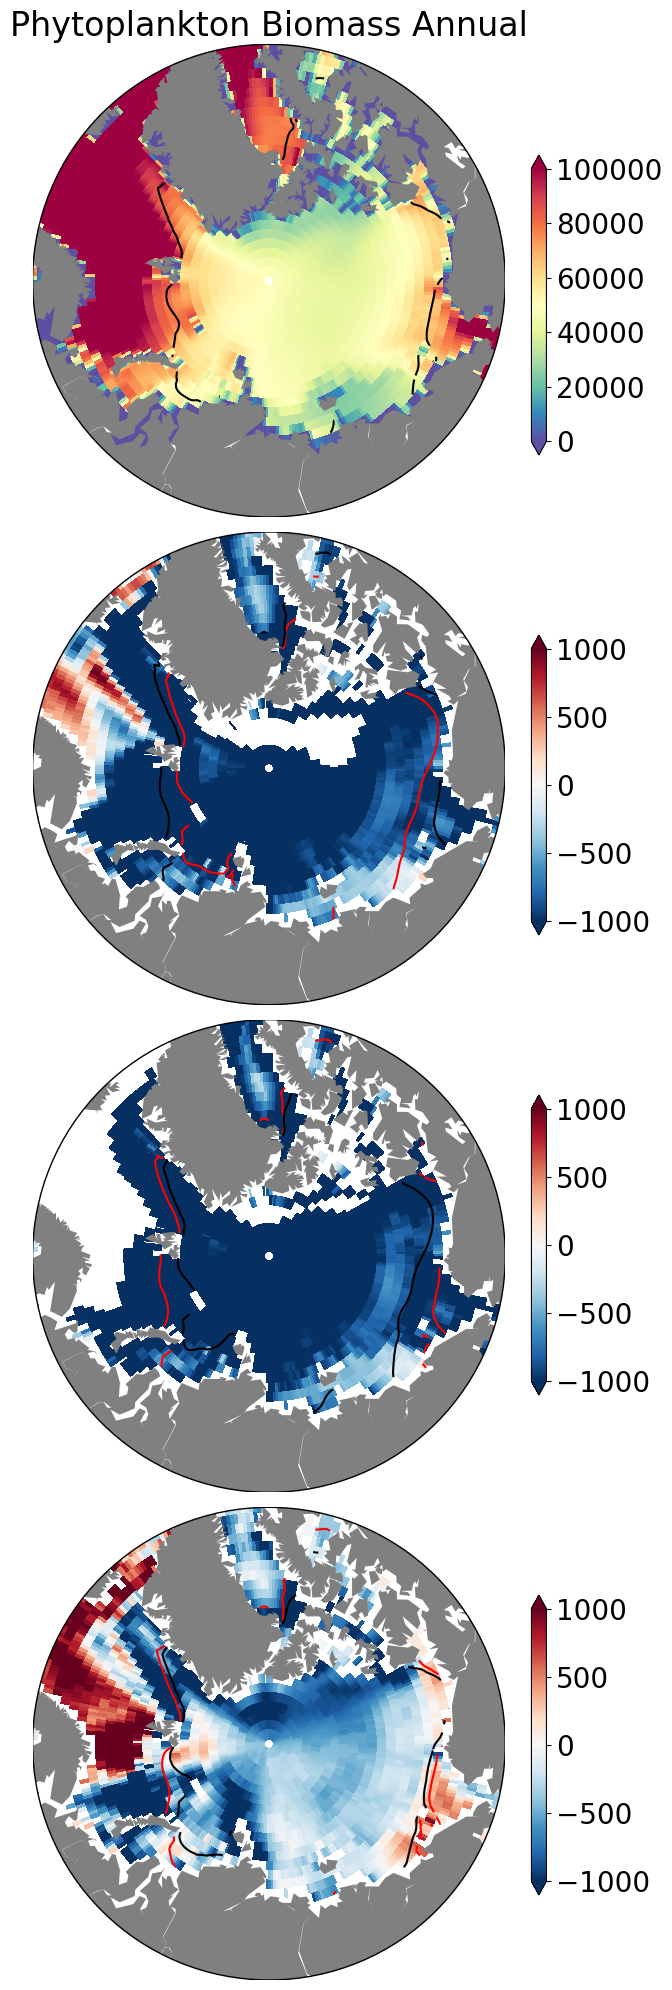

In [38]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(15, 20))
colorss = colors.LogNorm(vmin=0.01, vmax=10)
#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 1, 1)
ben, lon = add_cyclic_point(np.nansum(photoC_ao_clim,axis=0), coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x, y, ben, cmap='Spectral_r',vmin=0,vmax=100000);
benthic_ice, lon = add_cyclic_point(np.nanmean(ice_frac_annual,axis=0), coord=ds_03.lon, axis=1)
cs = m.contour(x, y, benthic_ice,levels = [0.7],colors='k');
ax.set_title('Phytoplankton Biomass Annual', fontsize =24)
cbar_ax = fig.add_axes([0.675, 0.77, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn=-1000
vmaxx=1000                                
# Benthic 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 1, 2)
b_temp_diff = low_temp_years_annual-high_temp_years_annual
b_diff, lon = add_cyclic_point(b_temp_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
ice_low, lon = add_cyclic_point(low_temp_years_annual_ice, coord=ds_03.lon, axis=1)
ice_high, lon = add_cyclic_point(high_temp_years_annual_ice, coord=ds_03.lon, axis=1)
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
cbar_ax = fig.add_axes([0.675, 0.53, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
## Ice Fraction

# Benthic 
# high-low/low years. 
ax = fig.add_subplot(4, 1, 3)
b_ice_diff = ((high_ice_years_annual-low_ice_years_annual))
b_diff, lon = add_cyclic_point(b_ice_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
ice_low, lon = add_cyclic_point(low_ice_years_annual_ice, coord=ds_03.lon, axis=1)
ice_high, lon = add_cyclic_point(high_ice_years_annual_ice, coord=ds_03.lon, axis=1)
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
cbar_ax = fig.add_axes([0.675, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# Ratio 
# high-low/high years NO3
ax = fig.add_subplot(4, 1, 4)
r_no3_diff = high_no3_years_annual-low_no3_years_annual
r_diff, lon = add_cyclic_point(r_no3_diff, coord=ds_03.lon, axis=1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, r_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
ice_low, lon = add_cyclic_point(low_no3_years_annual_ice, coord=ds_03.lon, axis=1)
ice_high, lon = add_cyclic_point(high_no3_years_annual_ice, coord=ds_03.lon, axis=1)
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
cbar_ax = fig.add_axes([0.675, 0.05, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()

#fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_biomass_annual_high_vs_low_T_N_Ice.png',dpi=600, bbox_inches='tight')


	• Throughout most of the Arctic Ocean region, when temperatures are higher, ice coverage is lower, even if nutrient concentrations are lower, the amount of phytoplankton present tends to be higher.
		○ The increases in temperature and decreases in ice fraction lead to increased availability of light, which can directly alleviate light limitation leading to an increase in phytoplankton production. 
		○ This increase in phytoplankton may in turn be responsible for the decrease in nutrient concentrations throughout the Arctic region.
	• In the North Atlantic inflow regions of the Nordic Sea, you see higher biomass in years with lower temperatures and higher nutrient concentrations. 
		○ Regions outside the ice zone are less affected by light limitation caused by ice coverage. Therefore, increased nutrient concentrations in these regions are the main driver of higher phytoplankton biomass, independent of changes in temperature or ice coverage.

### These results demonstrate how phytoplankton production in light-limited areas of the Arctic Ocean affects nutrient concentrations, highlighting the complex feedback mechanisms at play.
----------------------------
----------------------------

### NEXT STEP:  Create a scatter plot of the anomalies in phytoplankton biomass with the anomalies on temperature in the x axis. 

In [36]:
import matplotlib.pyplot as plt

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [37]:
variable = 'temp'
phyto_variable = 'biomass'
caption_y = 'photoC'
caption_x1 = 'ice'
caption_x2 = 'temp'
caption_x3 = 'NO$_3$'

In [38]:
%%time
# For every grid cell in the Arctic Ocean 
# Create empty arrays filled with NaN's 
photoc_arctic_anom = np.empty([62,12,180,360]) ; photoc_arctic_anom[:] = np.nan

# Loop through the latitudes and longitudes to calculate anomalies and error values. 
for latitude in np.arange(149,180,1):
    for longitude in np.arange(0,360,1):
        photoc_arctic_anom[:,:,latitude,longitude] = photoC_TOT[:,:,latitude,longitude]-photoC_ao_clim[:,latitude,longitude]

CPU times: user 153 ms, sys: 144 ms, total: 297 ms
Wall time: 315 ms


## Now let's import the limitation terms for 

In [ ]:
path_to_regrid = '/glade/u/home/gabyn/scratch/SPECTRA/growth_lim'
phyto_lim = 'diat1_lim'
ds_diat1_index= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat1_limitation_index.nc",concat_dim='time', combine='nested') 
ds_diat1_value= xr.open_mfdataset(f"{path_to_regrid}/regrid_diat1_limitation_value.nc",concat_dim='time', combine='nested') 

In [51]:
annual_diat1_lim = np.array(ds_diat1_value.diat1_lim_value)
annual_diat1_index = np.array(ds_diat1_index.diat1_lim_index)

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

In [53]:
diat1_lims = (ds_diat1_value.diat1_lim_value.where(annual_diat1_lim < 0.9) + ds_diat1_index.diat1_lim_index.where(annual_diat1_lim < 0.9))

## Colorbar 

In [59]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),(0.45066769191336664, 0.7509983339741125, 0.7703857490708702),(0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

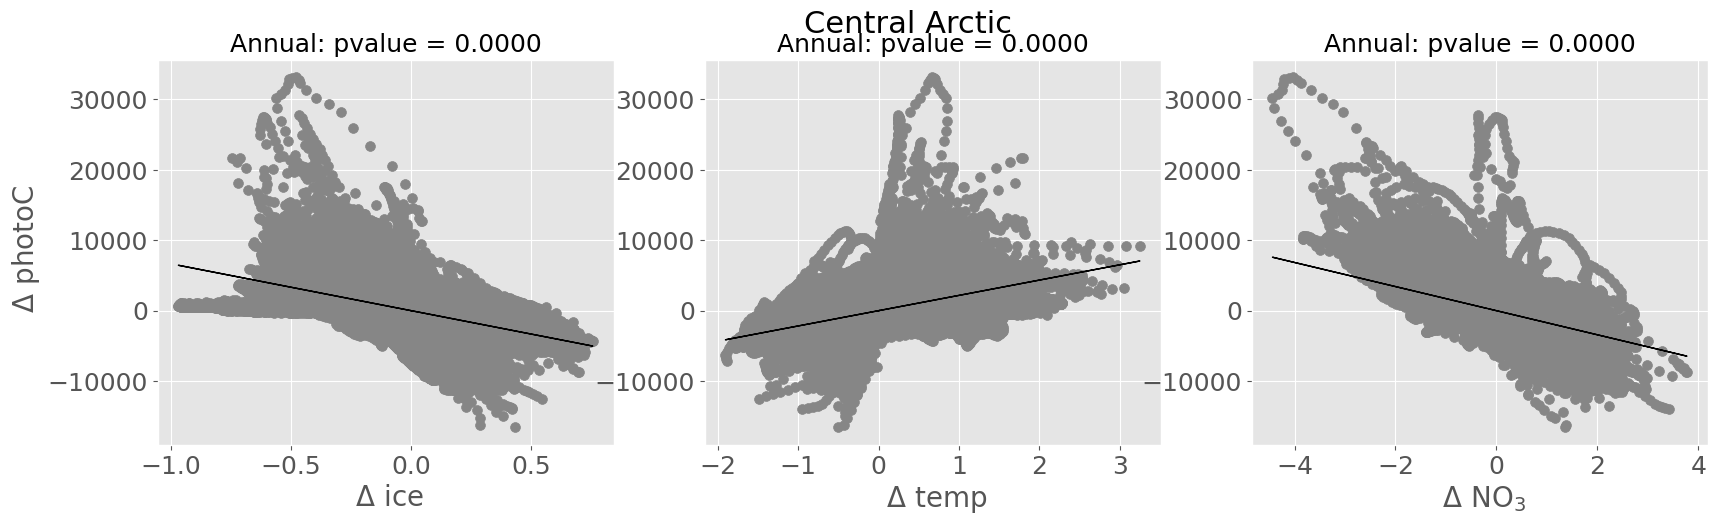

In [93]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,170:180,:].flatten()
X1 = ice_arctic_anom[:,:,170:180,:].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,170:180,:].flatten()
X2 = temp_arctic_anom[:,:,170:180,:].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,170:180,:].flatten()
X3 = no3_arctic_anom[:,:,170:180,:].flatten()
lim_X = np.array(diat1_lims[1::,:,170:180,:]).flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Central Arctic'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

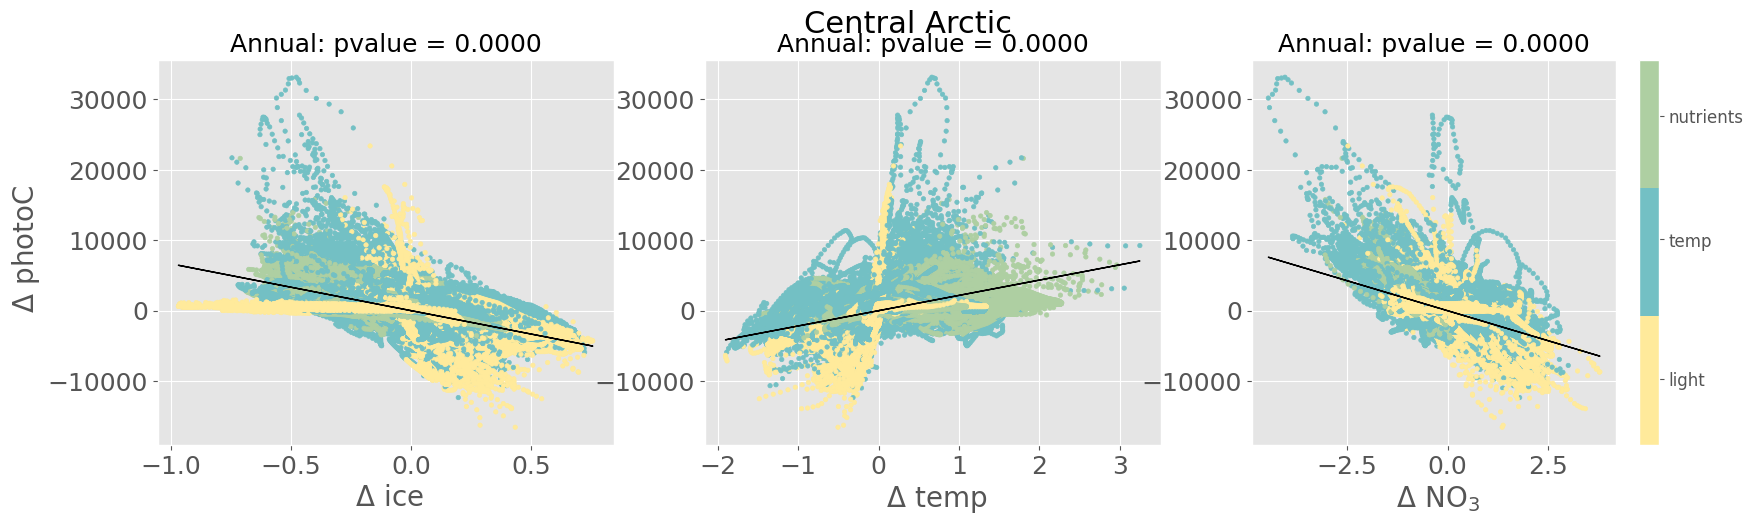

In [91]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,170:180,:].flatten()
X1 = ice_arctic_anom[:,:,170:180,:].flatten()
lim_X = np.array(diat1_lims[1::,:,170:180,:]).flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
#ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,170:180,:].flatten()
X2 = temp_arctic_anom[:,:,170:180,:].flatten()
lim_X = np.array(diat1_lims[1::,:,170:180,:]).flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
#ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,170:180,:].flatten()
X3 = no3_arctic_anom[:,:,170:180,:].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,170:180,:]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
#ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Central Arctic'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_diat1_limitation.png',dpi=600, bbox_inches='tight')

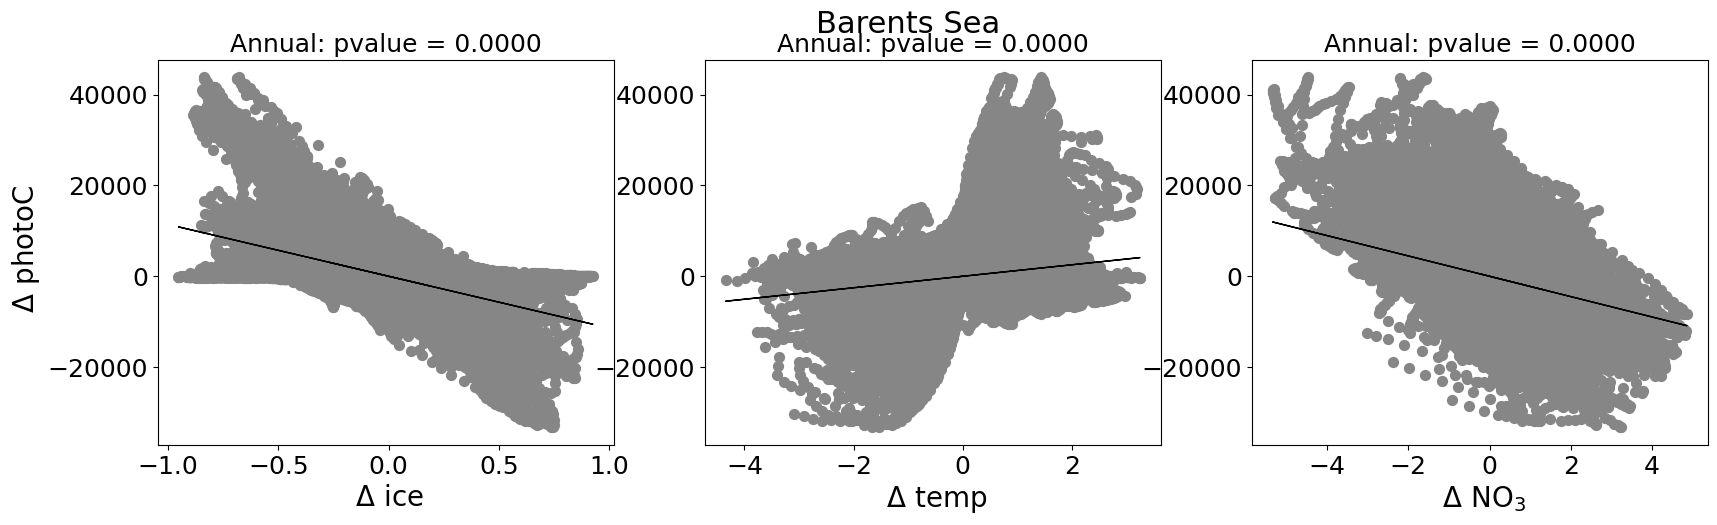

In [55]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X1 = ice_arctic_anom[:,:,149:170,205:233].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X2 = temp_arctic_anom[:,:,149:170,205:233].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X3 = no3_arctic_anom[:,:,149:170,205:233].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Barents Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

NameError: name 'phyto_lim' is not defined

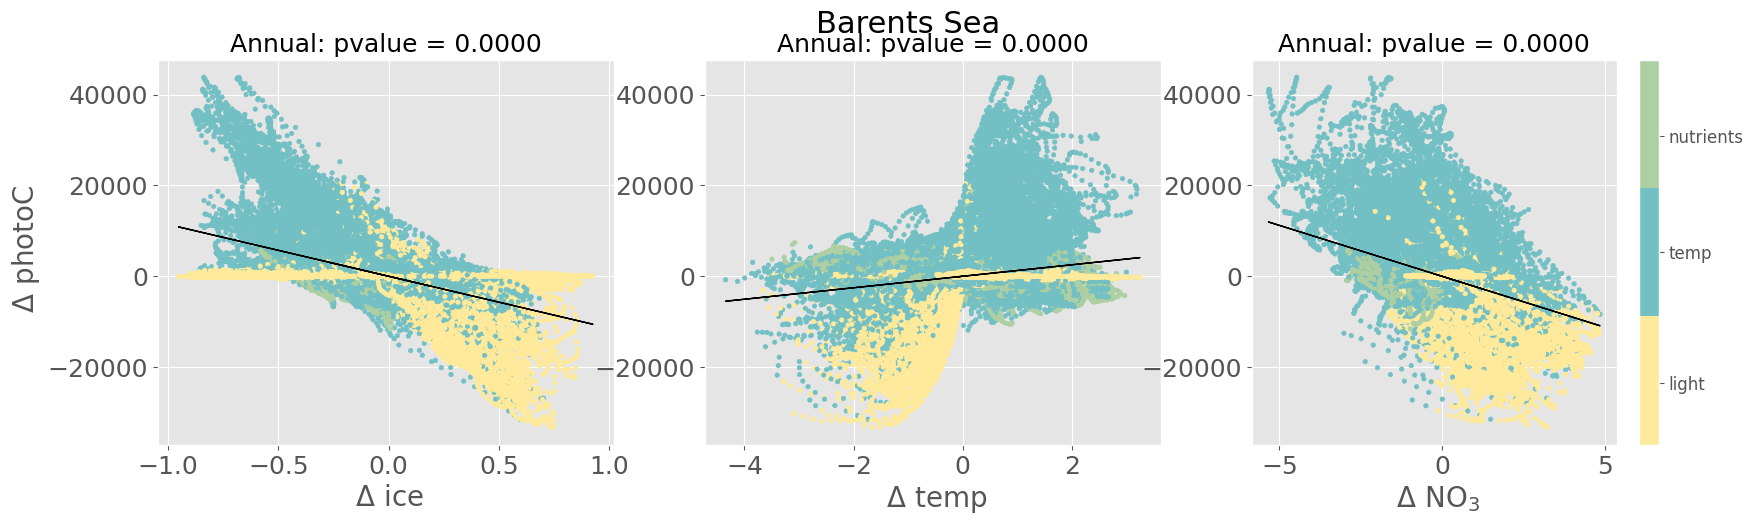

In [94]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X1 = ice_arctic_anom[:,:,149:170,205:233].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,205:233]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X2 = temp_arctic_anom[:,:,149:170,205:233].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,205:233]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,205:233].flatten()
X3 = no3_arctic_anom[:,:,149:170,205:233].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,205:233]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Barents Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

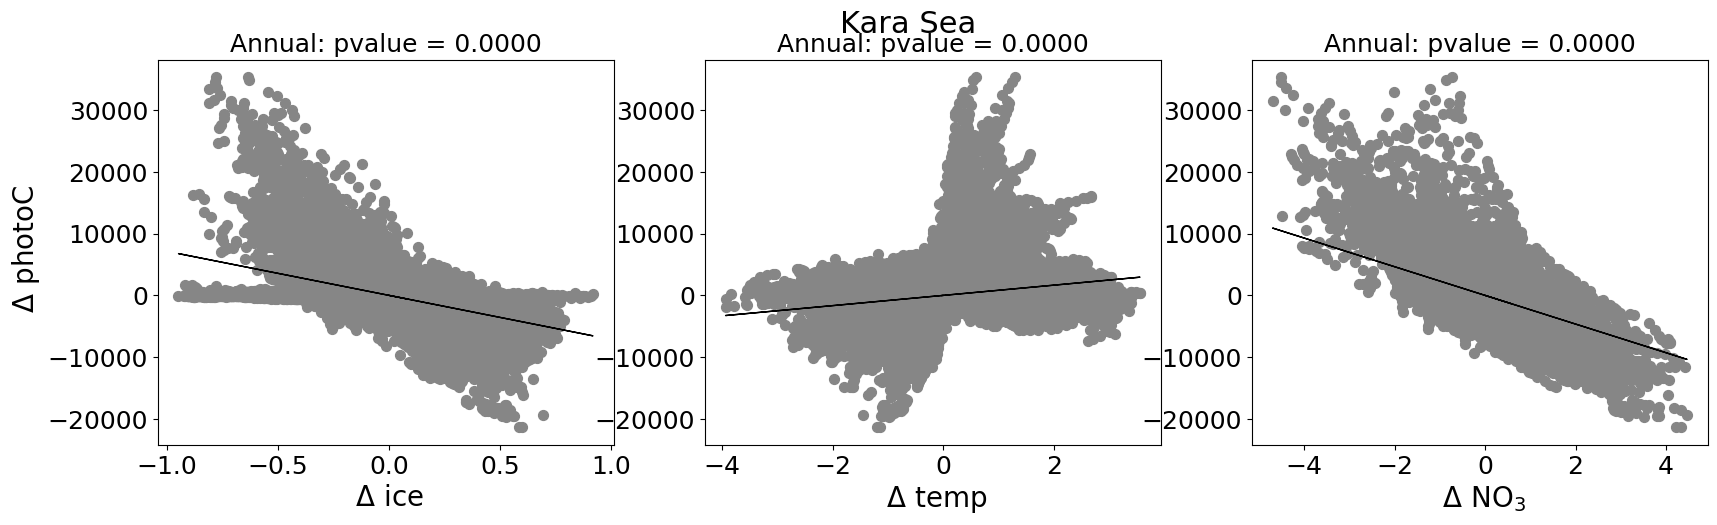

In [56]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X1 = ice_arctic_anom[:,:,149:170,233:270].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X2 = temp_arctic_anom[:,:,149:170,233:270].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X3 = no3_arctic_anom[:,:,149:170,233:270].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Kara Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

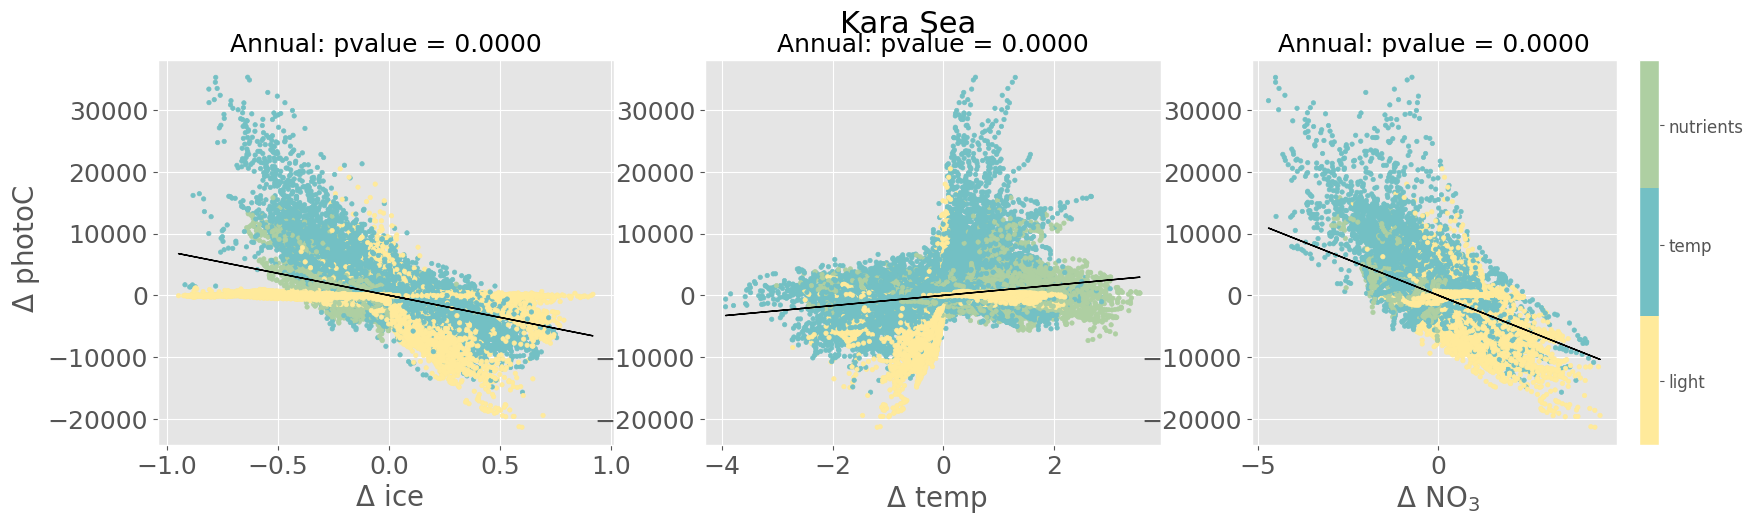

In [97]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X1 = ice_arctic_anom[:,:,149:170,233:270].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,233:270]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X2 = temp_arctic_anom[:,:,149:170,233:270].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,233:270]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,233:270].flatten()
X3 = no3_arctic_anom[:,:,149:170,233:270].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,233:270]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Kara Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

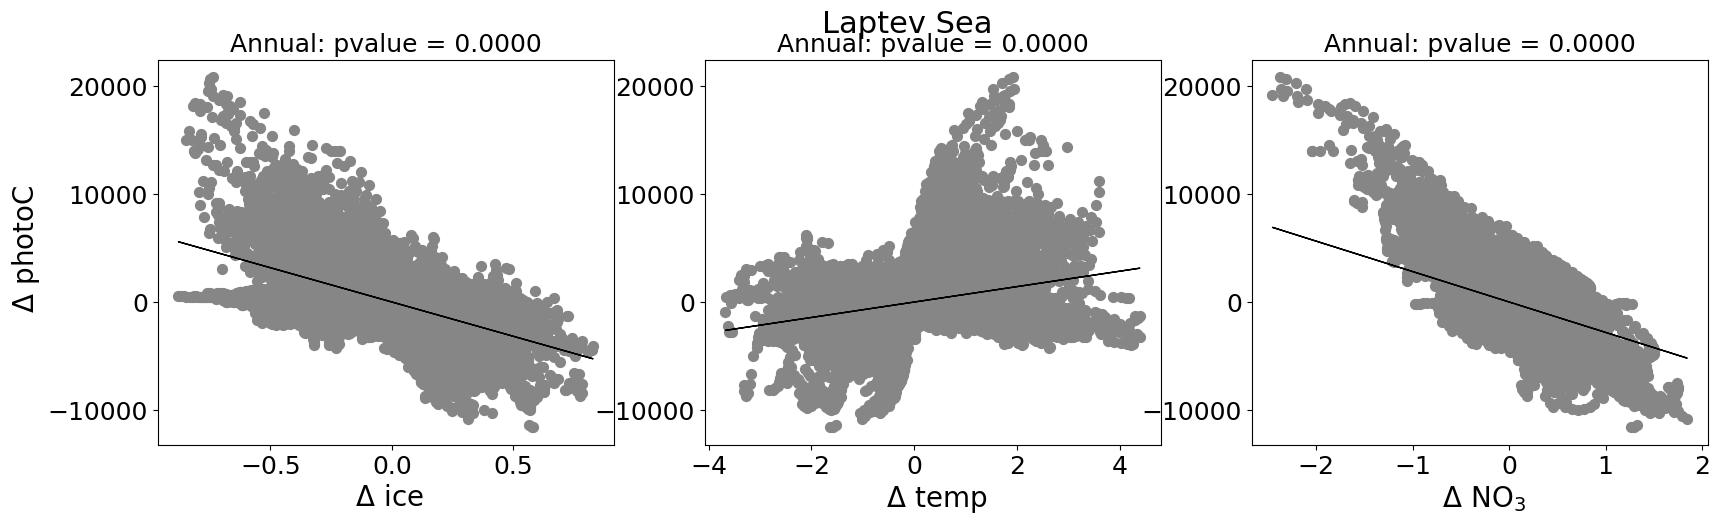

In [57]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X1 = ice_arctic_anom[:,:,149:170,270:325].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X2 = temp_arctic_anom[:,:,149:170,270:325].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X3 = no3_arctic_anom[:,:,149:170,270:325].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Laptev Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

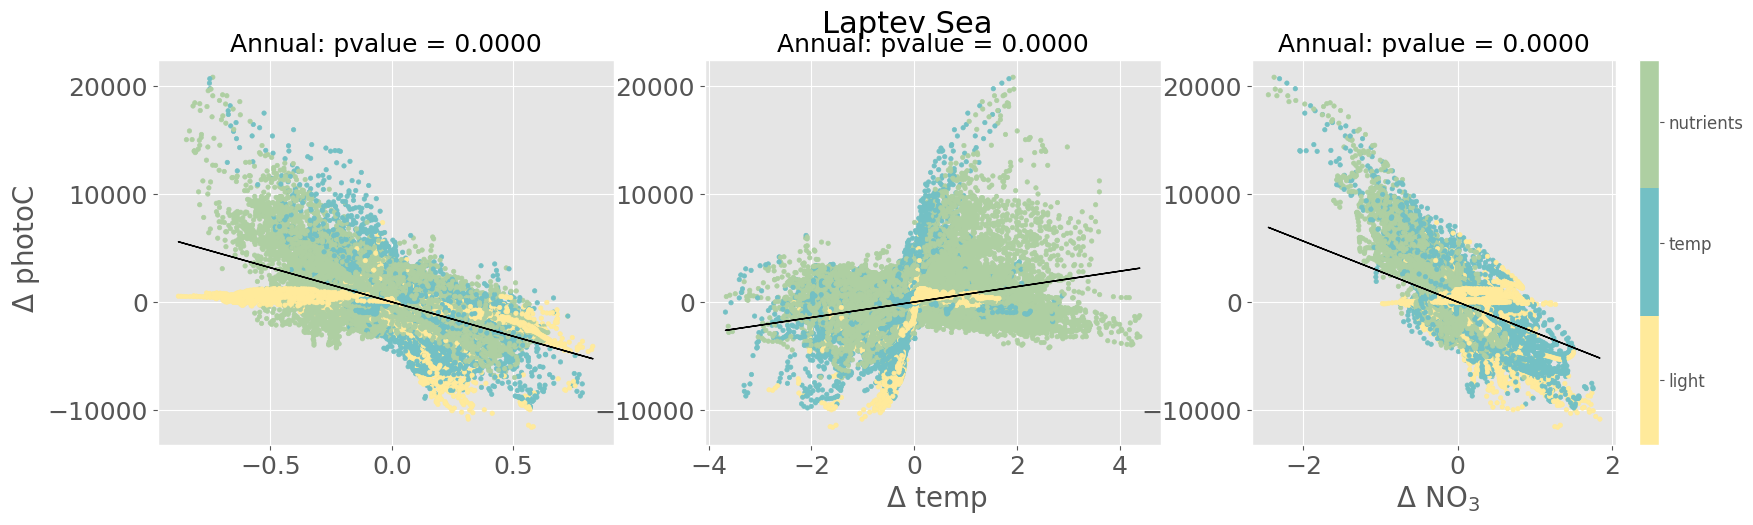

In [100]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X1 = ice_arctic_anom[:,:,149:170,270:325].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
lim_X = np.array(diat1_lims[1::,:,149:170,270:325]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X2 = temp_arctic_anom[:,:,149:170,270:325].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,270:325]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,270:325].flatten()
X3 = no3_arctic_anom[:,:,149:170,270:325].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,270:325]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Laptev Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

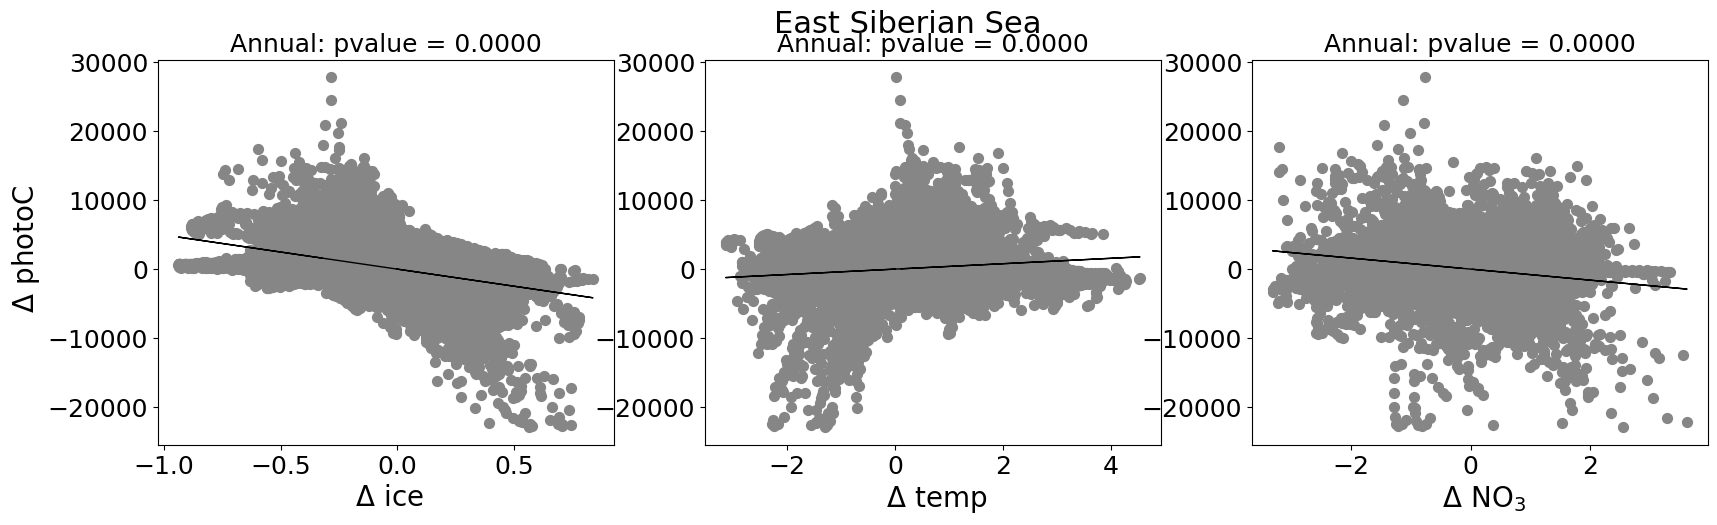

In [58]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X1 = ice_arctic_anom[:,:,149:170,325:360].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X2 = temp_arctic_anom[:,:,149:170,325:360].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X3 = no3_arctic_anom[:,:,149:170,325:360].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'East Siberian Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

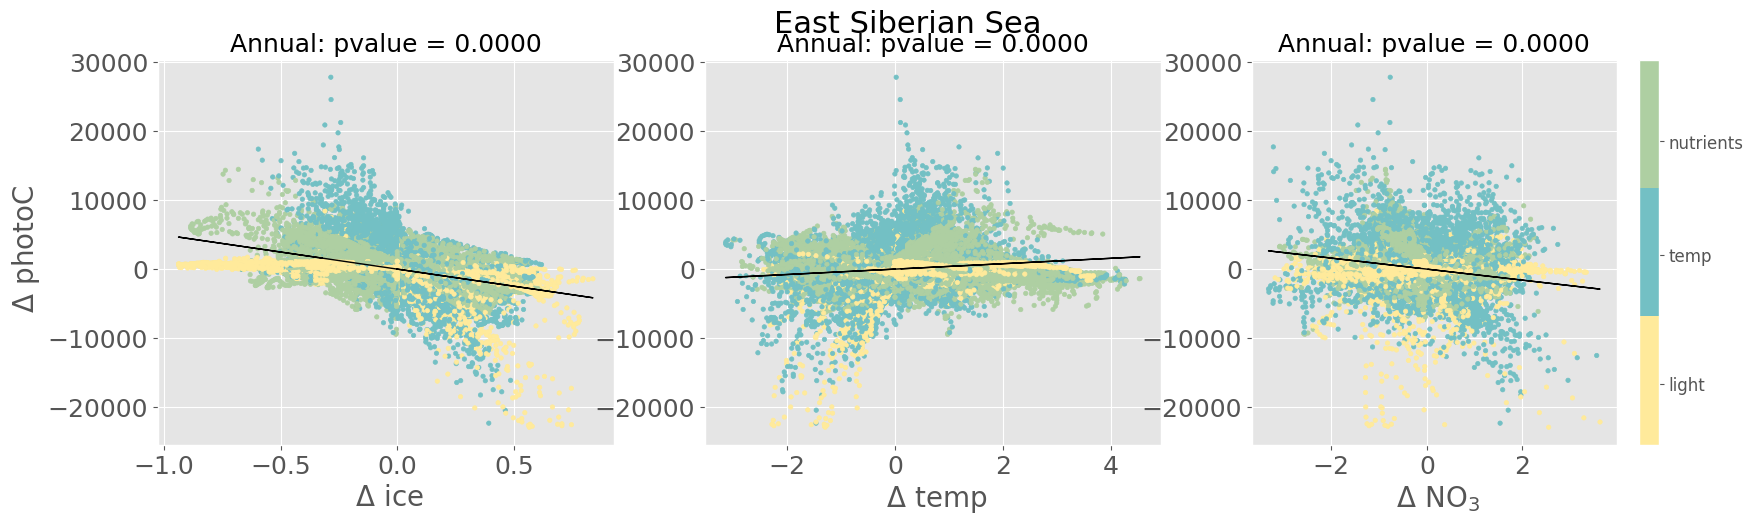

In [99]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X1 = ice_arctic_anom[:,:,149:170,325:360].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,325:360]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X2 = temp_arctic_anom[:,:,149:170,325:360].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,325:360]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,325:360].flatten()
X3 = no3_arctic_anom[:,:,149:170,325:360].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,325:360]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'East Siberian Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

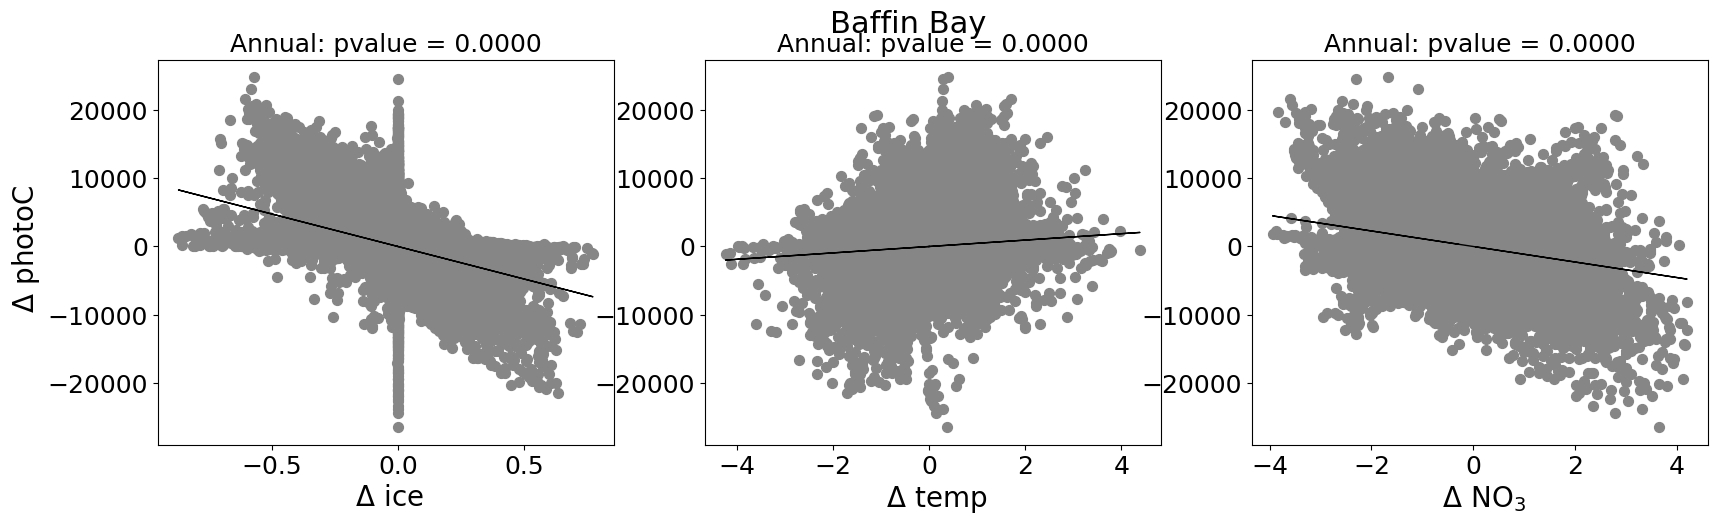

In [59]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X1 = ice_arctic_anom[:,:,149:170,110:135].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X2 = temp_arctic_anom[:,:,149:170,110:135].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X3 = no3_arctic_anom[:,:,149:170,110:135].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Baffin Bay'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

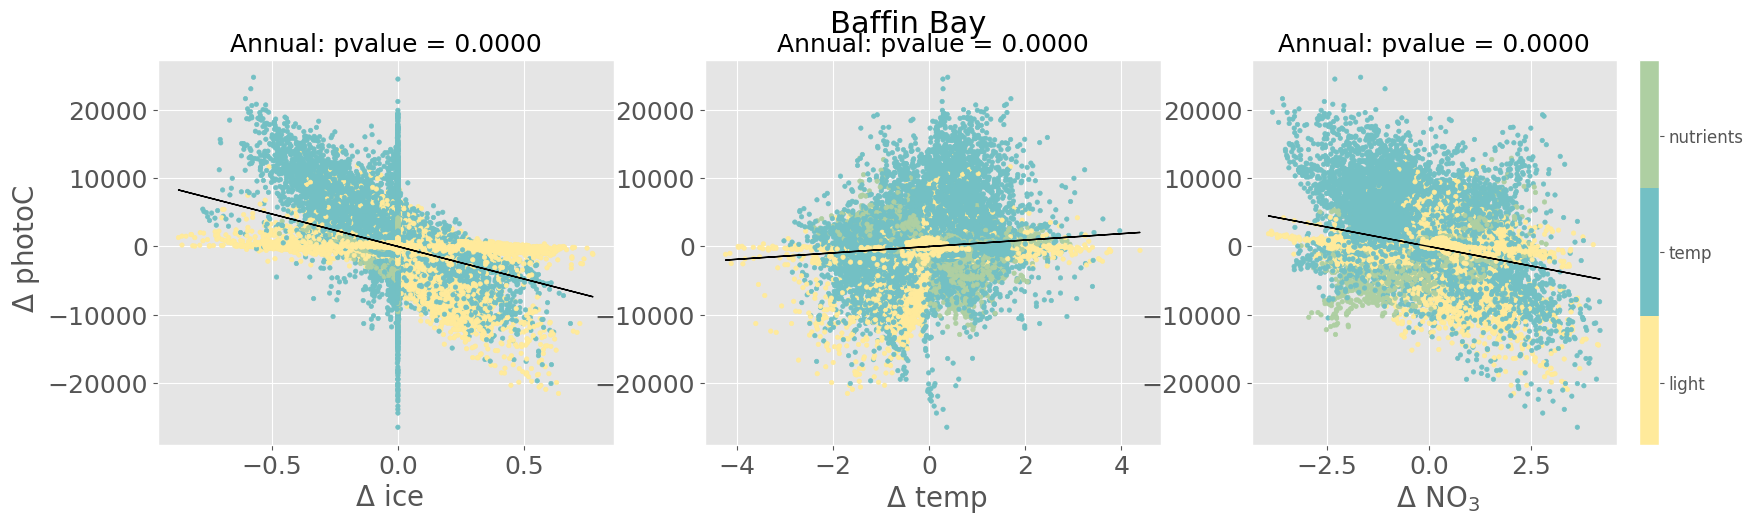

In [101]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X1 = ice_arctic_anom[:,:,149:170,110:135].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,110:135]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X2 = temp_arctic_anom[:,:,149:170,110:135].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,110:135]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,110:135].flatten()
X3 = no3_arctic_anom[:,:,149:170,110:135].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,110:135]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Baffin Bay'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

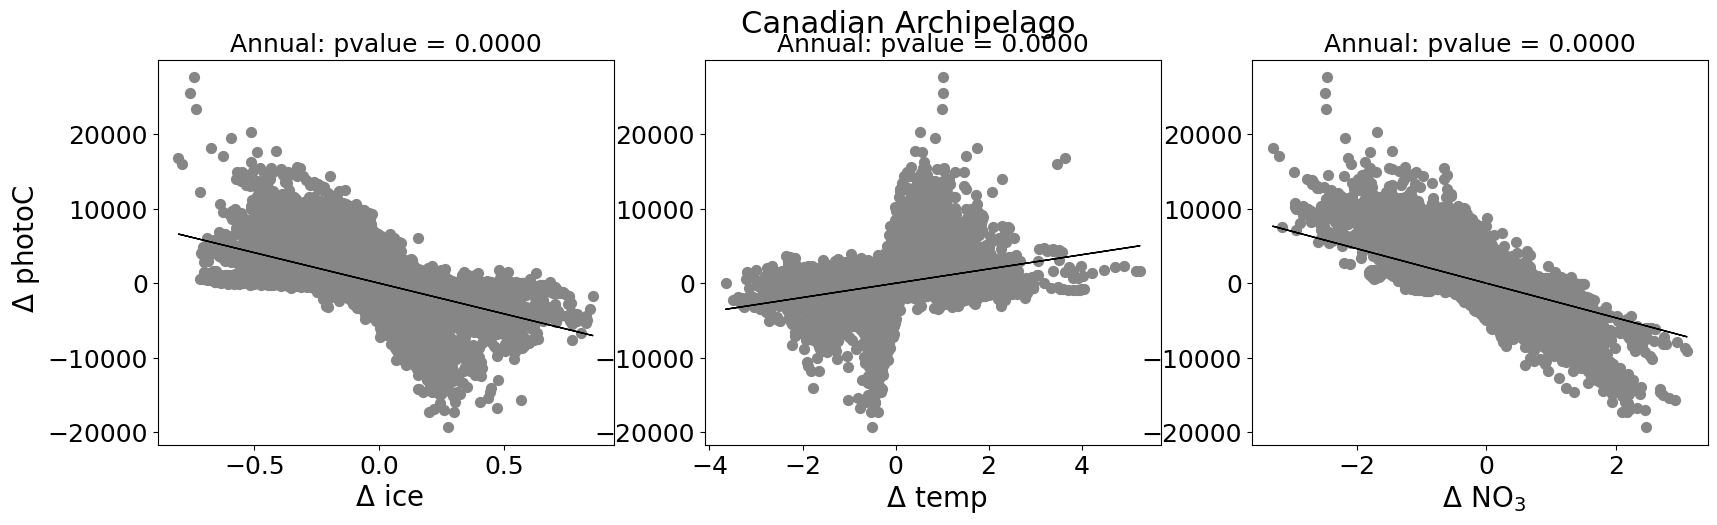

In [60]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X1 = ice_arctic_anom[:,:,149:170,55:110].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X2 = temp_arctic_anom[:,:,149:170,55:110].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X3 = no3_arctic_anom[:,:,149:170,55:110].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Canadian Archipelago'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

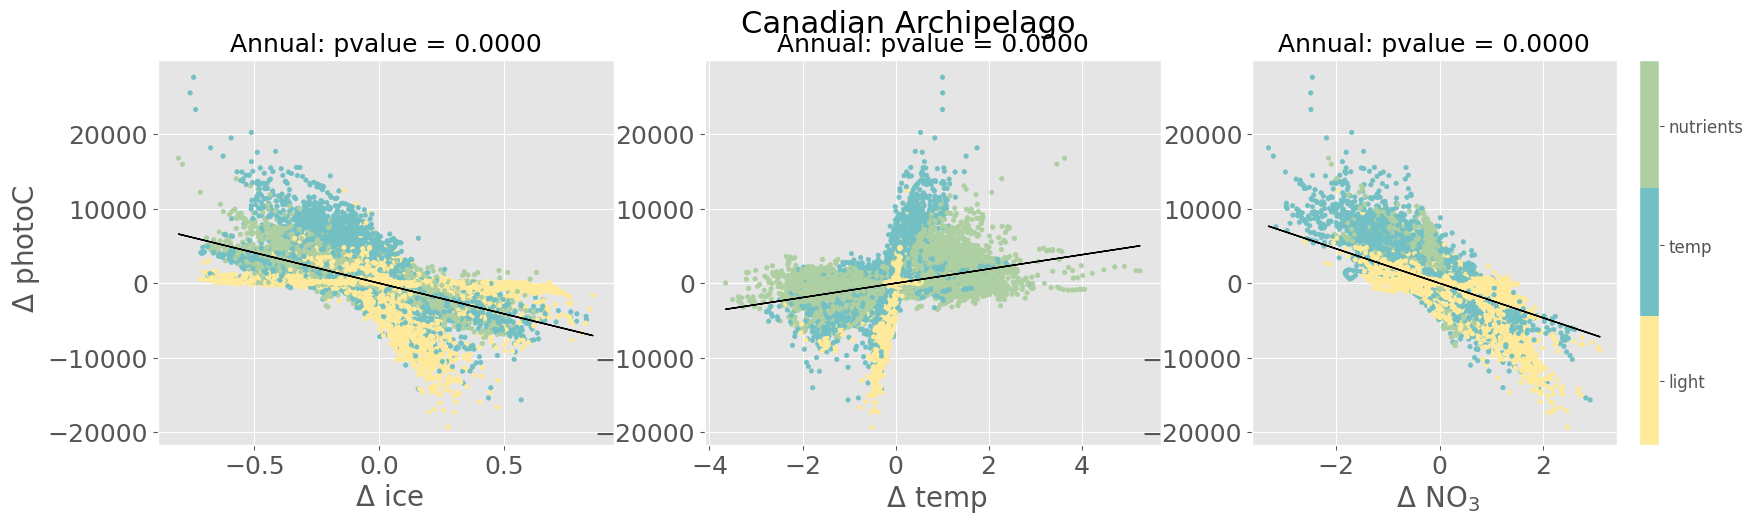

In [102]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X1 = ice_arctic_anom[:,:,149:170,55:110].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,55:110]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X2 = temp_arctic_anom[:,:,149:170,55:110].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,55:110]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,55:110].flatten()
X3 = no3_arctic_anom[:,:,149:170,55:110].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,55:110]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Canadian Archipelago'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

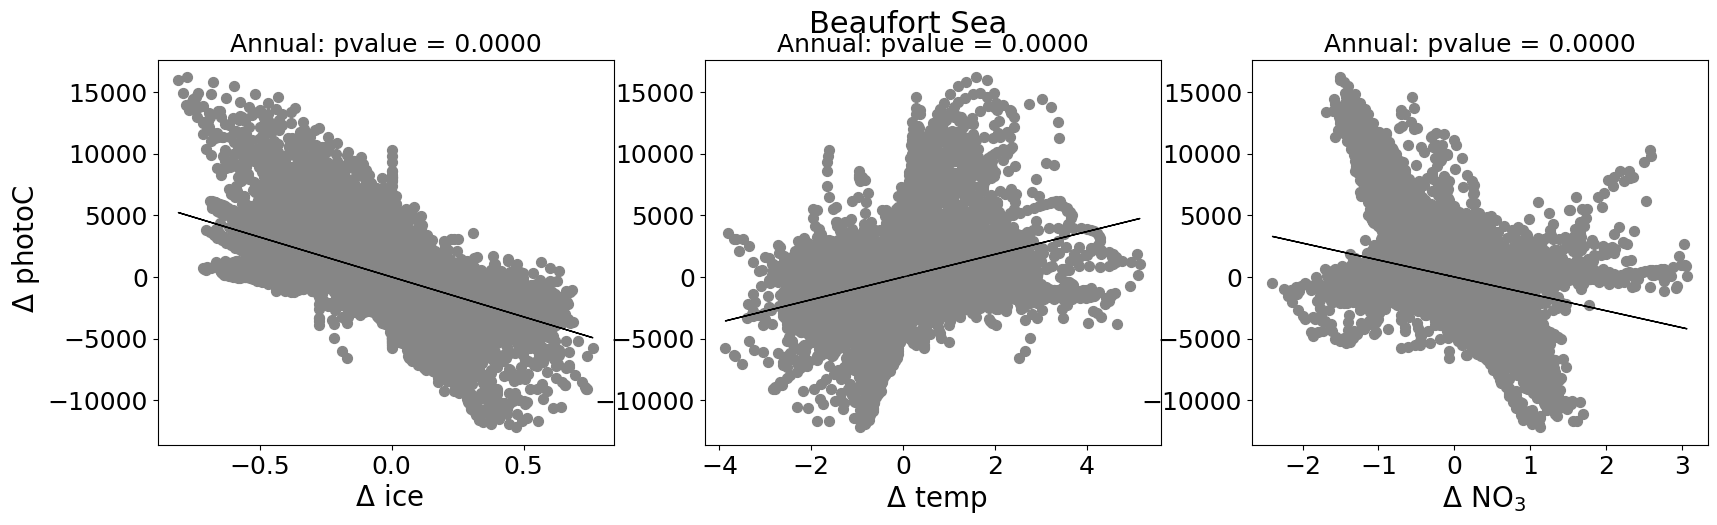

In [61]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X1 = ice_arctic_anom[:,:,149:170,25:55].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X2 = temp_arctic_anom[:,:,149:170,25:55].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X3 = no3_arctic_anom[:,:,149:170,25:55].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Beaufort Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

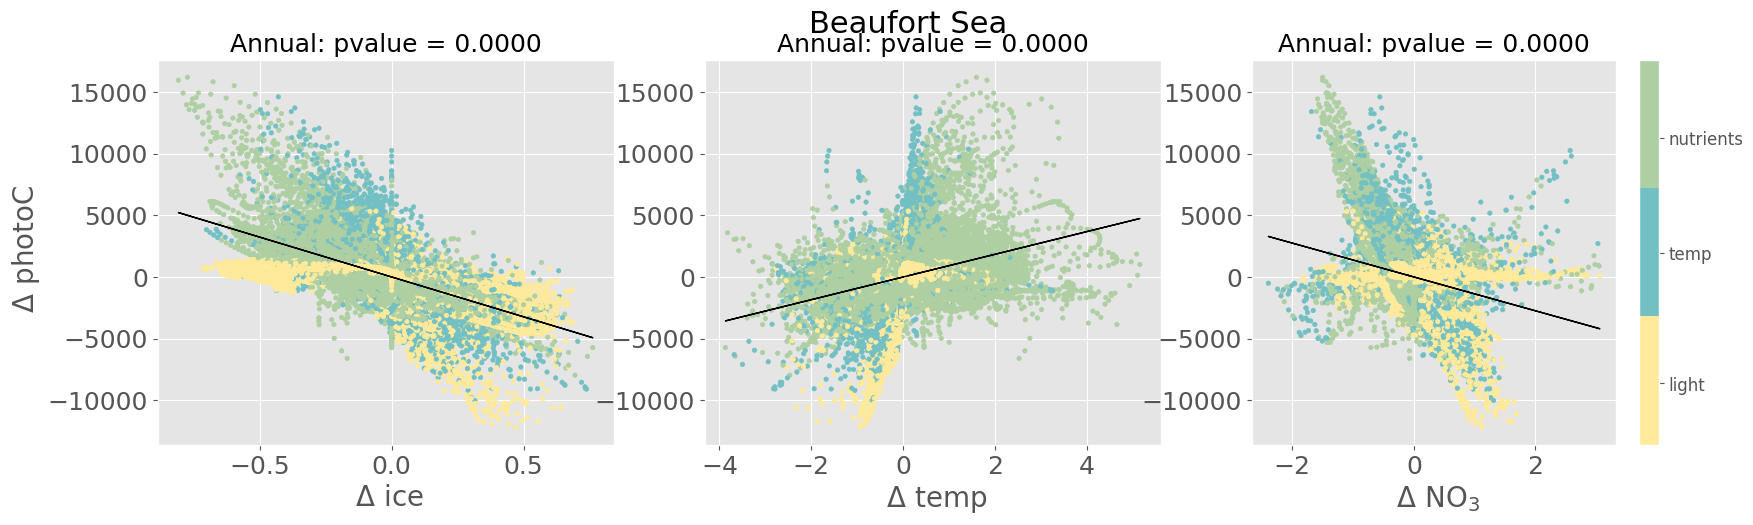

In [103]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X1 = ice_arctic_anom[:,:,149:170,25:55].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,25:55]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X2 = temp_arctic_anom[:,:,149:170,25:55].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,25:55]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,25:55].flatten()
X3 = no3_arctic_anom[:,:,149:170,25:55].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,25:55]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Beaufort Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

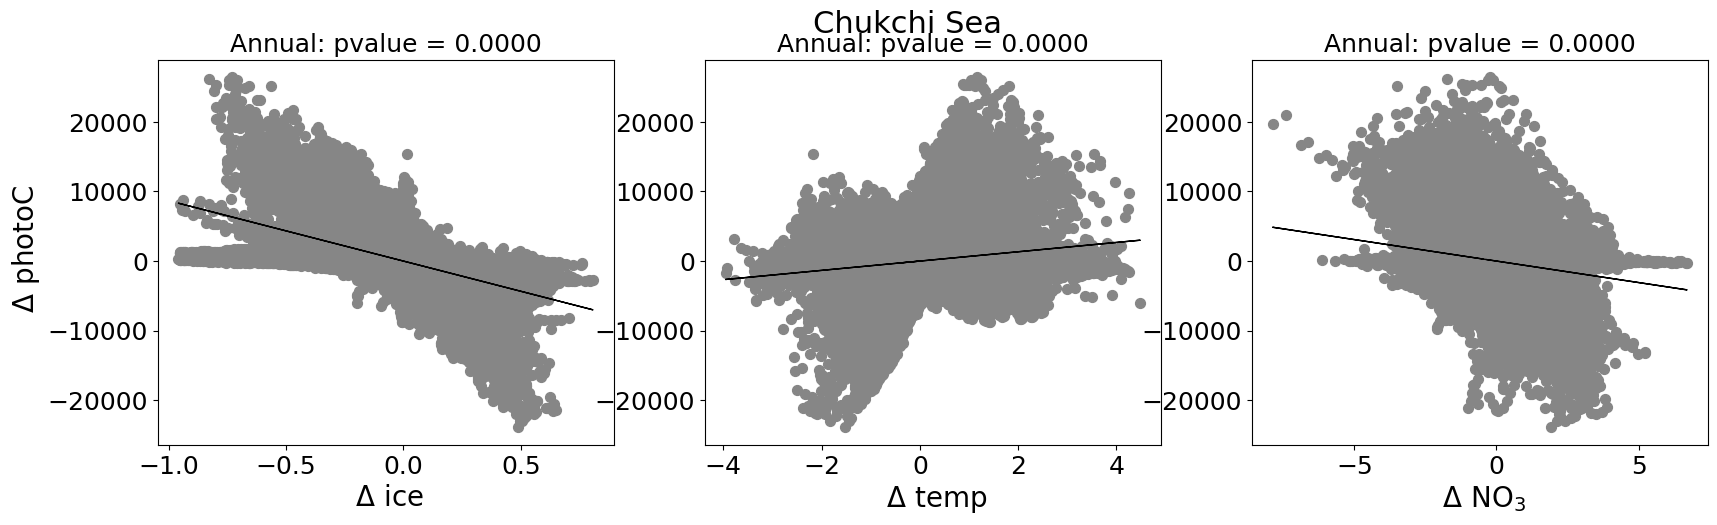

In [62]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X1 = ice_arctic_anom[:,:,149:170,0:25].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X2 = temp_arctic_anom[:,:,149:170,0:25].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X3 = no3_arctic_anom[:,:,149:170,0:25].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Chukchi Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

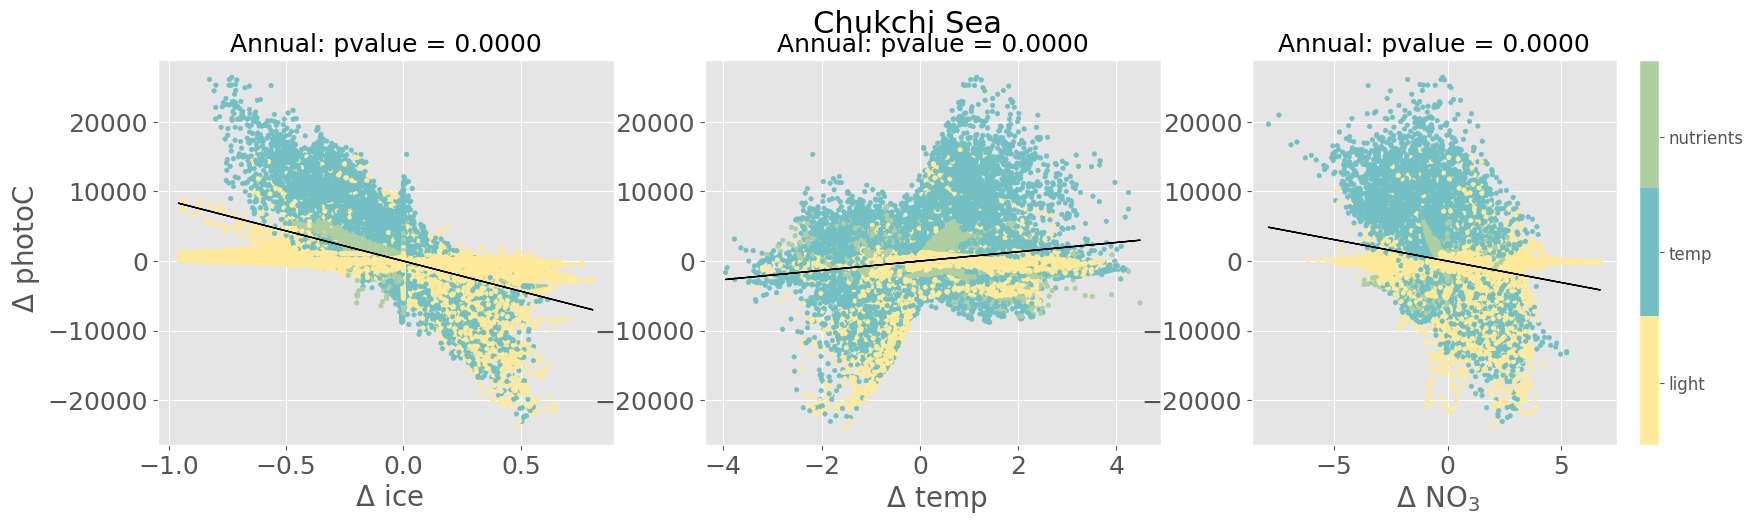

In [104]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X1 = ice_arctic_anom[:,:,149:170,0:25].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,0:25]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X2 = temp_arctic_anom[:,:,149:170,0:25].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,0:25]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,0:25].flatten()
X3 = no3_arctic_anom[:,:,149:170,0:25].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,0:25]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Chukchi Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')

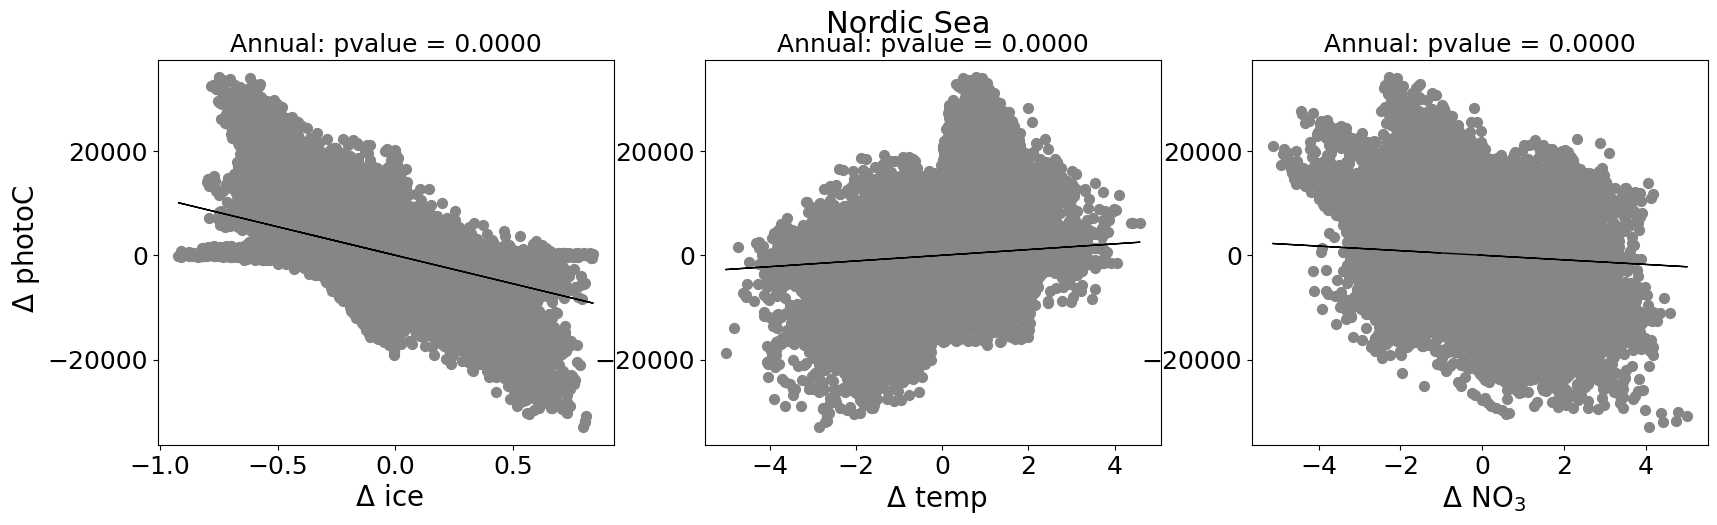

In [63]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X1 = ice_arctic_anom[:,:,149:170,155:205].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
ax.scatter(XX1, YY1, color = cmap1(4), s = 50)
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X2 = temp_arctic_anom[:,:,149:170,155:205].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
ax.scatter(XX2, YY2, color = cmap1(4), s = 50)
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X3 = no3_arctic_anom[:,:,149:170,155:205].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
ax.scatter(XX3, YY3, color = cmap1(4), s = 50)
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Nordic Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual.png',dpi=600, bbox_inches='tight')

		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_dim: ncid 0x3b0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_var_all: ncid 0x3b0000 varid 4
		NC4_inq_dim: ncid 0x3b0000 dimid 0
		NC4_inq_dim: ncid 0x3b0000 dimid 3
		NC4_inq_dim: ncid 0x3b0000 dimid 2
		NC4_inq_dim: ncid 0x3b0000 dimid 1
		NC4_inq_var_all: ncid 0x3b0000 varid 4
			NC4_get_vars: var->hdr.name diat1_lim_value mem_nc_type 6
		NC4_inq_dim: ncid

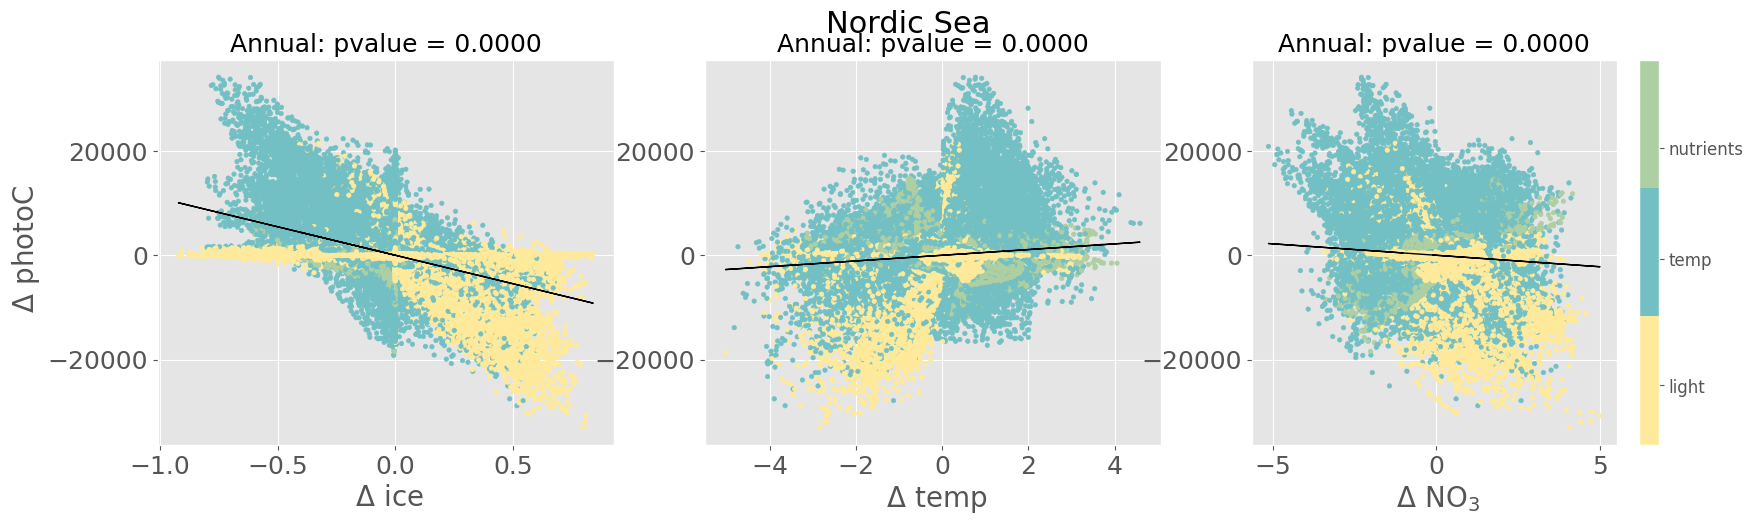

In [105]:
cmap1=matplotlib.cm.get_cmap('Greys_r', 10)

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,3,1) 
Y1 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X1 = ice_arctic_anom[:,:,149:170,155:205].flatten()
XX1 = X1[~np.isnan(Y1) & ~np.isnan(X1)]
YY1= Y1[~np.isnan(Y1) & ~np.isnan(X1)]
res1 = stats.linregress(XX1, YY1)
YYY1 = res1.intercept + res1.slope*XX1
ax.set_ylabel(f' $\u0394$ {caption_y}')
ax.set_xlabel(f' $\u0394$ {caption_x1}')
lim_X = np.array(diat1_lims[1::,:,149:170,155:205]).flatten()
X1_lim =lim_X[~np.isnan(Y1) & ~np.isnan(X1)]
cf = plt.scatter(y=YY1,x=XX1,c=X1_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX1, YYY1, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,2) 
Y2 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X2 = temp_arctic_anom[:,:,149:170,155:205].flatten()
XX2 = X2[~np.isnan(Y2) & ~np.isnan(X2)]
YY2= Y2[~np.isnan(Y2) & ~np.isnan(X2)]
res2 = stats.linregress(XX2, YY2)
YYY2 = res2.intercept + res2.slope*XX2
ax.set_xlabel(f' $\u0394$ {caption_x2}')
lim_X = np.array(diat1_lims[1::,:,149:170,155:205]).flatten()
X2_lim =lim_X[~np.isnan(Y2) & ~np.isnan(X2)]
cf = plt.scatter(y=YY2,x=XX2,c=X2_lim,s=10, alpha=1,cmap=cm);
ax.plot(XX2, YYY2, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

ax = fig.add_subplot(1,3,3) 
Y3 = photoc_arctic_anom[:,:,149:170,155:205].flatten()
X3 = no3_arctic_anom[:,:,149:170,155:205].flatten()
XX3 = X3[~np.isnan(Y3) & ~np.isnan(X3)]
YY3= Y3[~np.isnan(Y3) & ~np.isnan(X3)]
res3 = stats.linregress(XX3, YY3)
YYY3 = res3.intercept + res3.slope*XX3
ax.set_xlabel(f' $\u0394$ {caption_x3}')
lim_X = np.array(diat1_lims[1::,:,149:170,155:205]).flatten()
X3_lim =lim_X[~np.isnan(Y3) & ~np.isnan(X3)]
cf = plt.scatter(y=YY3,x=XX3,c=X3_lim,s=10, alpha=1,cmap=cm);
cbar = plt.colorbar(ticks=[0.4,1.25,2]);
cbar.ax.set_yticklabels(['light','temp', 'nutrients'], fontsize = 12);
ax.plot(XX3, YYY3, 'k', linewidth = 1, label='fitted line')
ax.set_title(f'Annual: pvalue = {res1.pvalue:.4f}')

region = 'Nordic Sea'
fig.suptitle(f'{region}')
fig.savefig(f'/glade/work/gabyn/case_notes/analysis_figures/{region[0:4]}_scatter_{phyto_variable}_anom_annual_{phyto_lim}.png',dpi=600, bbox_inches='tight')